In [3]:
from sklearn.model_selection import train_test_split
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import *
import torch,torchvision
from tqdm import tqdm
device = 'cuda'
PROJECT_NAME = 'Satellite-Image-Classification'

In [8]:
def load_data():
    idx = -1
    labels = {}
    data = []
    for folder in tqdm(os.listdir('./data/')):
        idx += 1
        labels[folder] = idx
        for file in os.listdir(f'./data/{folder}'):
            file = f'./data/{folder}/{file}'
            img = cv2.imread(file)
            img = cv2.resize(img,(112,112))
            data.append([img/255.0,labels[folder]])
    np.random.shuffle(data)
    X = []
    y = []
    for d in data:
        X.append(d[0])
        y.append(d[1])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.0625)
    return data,X,y,idx,labels,X_train,X_test,y_train,y_test

In [9]:
data,X,y,idx,labels,X_train,X_test,y_train,y_test = load_data()

100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


In [19]:
labels_r = {}
for l_key,l_val in zip(labels.keys(),labels.values()):
    labels_r[l_val] = l_key

In [23]:
labels

{'green_area': 0, 'cloudy': 1, 'desert': 2, 'water': 3}

In [31]:
len(X_train)

5279

In [32]:
len(y_train)

5279

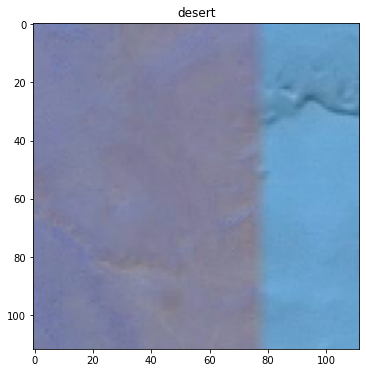

In [36]:
plt.figure(figsize=(12,6))
plt.title(f'{labels_r[y_test[2]]}')
plt.imshow(X_test[2])

In [38]:
def get_loss(model,X,y,criterion):
    preds = model(X)
    loss = criterion(preds,y)
    return loss.item()
def get_accuracy(model,X,y):
    total = -1
    correct = -1
    preds = model(X)
    for y_batch,pred in zip(y,preds):
        pred = torch.argmax(pred)
        if y_batch == pred:
            correct += 1
        total += 1
    acc = round(correct/total,3)*100
    return acc
def predict(model):
    preds = []
    for img in os.listdir('./test_data/'):
        img = cv2.imread(f'./test_data/{img}')
        img = cv2.resize(img,(112,112))
        img = img / 255.0
        pred = model(img)
        pred = torch.argmax(pred)
        plt.figure(figsize=(12,7))
        plt.imshow(img)
        plt.title(f'{labels[pred]}')
        plt.savefig(f'./preds/{img}')
        plt.close()

In [40]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(3,6,(3,3))
        self.conv1batchnorm = BatchNorm2d(6)
        self.conv2 = Conv2d(6,12,(3,3))
        self.conv2batchnorm = BatchNorm2d(12)
        self.conv3 = Conv2d(12,24,(3,3))
        self.conv3batchnorm = BatchNorm2d(24)
        self.conv4 = Conv2d(24,48,(3,3))
        self.conv4batchnorm = BatchNorm2d(48)
        self.conv5 = Conv2d(48,96,(3,3))
        self.conv5batchnorm = BatchNorm2d(96)
        self.linear1 = Linear(96*10*10,128)
        self.linear1batchnorm = BatchNorm1d(128)
        self.linear2 = Linear(128,256)
        self.linear2batchnorm = BatchNorm1d(256)
        self.linear3 = Linear(256,512)
        self.linear3batchnorm = BatchNorm1d(512)
        self.linear4 = Linear(512,1024)
        self.linear4batchnorm = BatchNorm1d(1024)
        self.linear5 = Linear(1024,512)
        self.linear5batchnorm = BatchNorm1d(512)
        self.output = Linear(512,1)
    
    def forward(self,X):
        preds = X
        preds = self.activation(self.max_pool2d(self.conv1batchnorm(self.conv1(preds))))
        preds = self.activation(self.max_pool2d(self.conv2batchnorm(self.conv2(preds))))
        preds = self.activation(self.max_pool2d(self.conv3batchnorm(self.conv3(preds))))
        preds = self.activation(self.max_pool2d(self.conv4batchnorm(self.conv4(preds))))
        preds = self.activation(self.max_pool2d(self.conv5batchnorm(self.conv5(preds))))
        print(preds.shape)
        preds = preds.view(-1,96*10*10)
        preds = self.activation(self.linear1batchnorm(self.linear1(preds)))
        preds = self.activation(self.linear2batchnorm(self.linear2(preds)))
        preds = self.activation(self.linear3batchnorm(self.linear3(preds)))
        preds = self.activation(self.linear4batchnorm(self.linear4(preds)))
        preds = self.activation(self.linear5batchnorm(self.linear5(preds)))
        preds = self.output(preds)
        return preds

In [42]:
model = Model().to(device)

In [43]:
criterion = CrossEntropyLoss()

In [45]:
from torch.optim import *

In [46]:
optimizer = Adam(model.parameters(),lr=0.001)

In [47]:
epochs = 100

In [48]:
batch_size = 32

In [ ]:
import wandb

In [49]:
wandb.init(project=PROJECT_NAME,name='baseline')
wandb.watch(model)
for _ in tqdm(range(epochs)):
    for idx in range(0,len(X_train),idx):
        X_batch = X_train[idx:idx+batch_size].float().to(device)
        y_batch = y_train[idx:idx+batch_size].to(device)
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({'Loss':get_loss(model,X_train,y_train,criterion)})
    wandb.log({'Val Loss':get_loss(model,X_test,y_test,criterion)})
    wandb.log({'Acc':get_accuracy(model,X_train,y_train)})
    wandb.log({'Val Acc':get_accuracy(model,X_test,y_test)})
    predict(model)
    for file in os.listdir('./preds/'):
        wandb.log({f'Img/{file}':wandb.Image(cv2.imread(f'./preds/{file}'))})
wandb.watch(model)
wandb.finish()

NameError: name 'wandb' is not defined